In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPool1D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import he_normal, glorot_uniform
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from visualization_utility import plot_data
from prepare_NN_data import prepare_data
import h5py
import os
import sys

2024-07-29 13:12:58.077802: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 13:12:58.116201: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 13:12:58.116220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 13:12:58.117214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 13:12:58.123316: I tensorflow/core/platform/cpu_feature_guar

[NbConvertApp] Converting notebook visualization_utility.ipynb to script
[NbConvertApp] Writing 7408 bytes to visualization_utility.py
[NbConvertApp] Converting notebook prepare_NN_data.ipynb to script
[NbConvertApp] Writing 8260 bytes to prepare_NN_data.py


In [2]:
print(tf.__version__)

2.15.0


<h3>Load the data</h3>

In [3]:
# Folder where the input and output data are located
NN_data_path = "/fmi/projappl/project_2004400/jamin/data/libradtran_data/NN_data/"

In [4]:
data_dict = prepare_data(NN_data_path=NN_data_path,
                         output_var="edir",
                         train_prop=0.8,
                         val_prop=0.1,
                         test_prop=0.1)

2024-07-29 13:14:29.700933: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
data_dict.keys()

dict_keys(['scaled_X_train', 'scaled_X_val', 'scaled_X_test', 'Y_train_edir', 'Y_val_edir', 'Y_test_edir'])

In [6]:
scaled_X_train = data_dict["scaled_X_train"]
scaled_X_val = data_dict["scaled_X_val"]
scaled_X_test = data_dict["scaled_X_test"]
Y_train_edir = data_dict["Y_train_edir"]
Y_val_edir = data_dict["Y_val_edir"]
Y_test_edir = data_dict["Y_test_edir"]

In [7]:
print("############### Training data ###############")
print(f"Shape of scaled_X_train: {scaled_X_train.shape}")
print(f"Shape of Y_train_edir: {Y_train_edir.shape}")
print()
print("############### Validation data ###############")
print(f"Shape of scaled_X_val: {scaled_X_val.shape}")
print(f"Shape of Y_val_edir: {Y_val_edir.shape}")
print()
print("############### Test data ###############")
print(f"Shape of scaled_X_test: {scaled_X_test.shape}")
print(f"Shape of Y_test_edir: {Y_test_edir.shape}")

############### Training data ###############
Shape of scaled_X_train: (1382, 53, 1)
Shape of Y_train_edir: (1382, 235002)

############### Validation data ###############
Shape of scaled_X_val: (172, 53, 1)
Shape of Y_val_edir: (172, 235002)

############### Test data ###############
Shape of scaled_X_test: (174, 53, 1)
Shape of Y_test_edir: (174, 235002)


In [8]:
edir_min = np.min(np.vstack([Y_train_edir.numpy(), Y_val_edir.numpy(), Y_test_edir.numpy()]))
edir_max = np.max(np.vstack([Y_train_edir.numpy(), Y_val_edir.numpy(), Y_test_edir.numpy()]))
print(f"Range of edir: [{edir_min}, {edir_max}]")

Range of edir: [0.0, 1666.6759033203125]


<h3>Train the model</h3>

In [9]:
def model(X_train, Y_train, X_val, Y_val, num_epochs: int, batch_size: int, output_var_name):
    """
    Builds, compiles, fits, plots the learning curve of the model, 
    and plots the emulator results vs. true values.
    
    Args:
    X -- the input dataset
    Y -- the output dataset
    num_epochs -- the number of epochs
    batch_size -- the batch size
    val_data -- validation data to be used in the training process of the NN
    output_var_name -- name of the output variable that the NN model predicts
    
    Prints:
    - train MSE
    - validation MSE
    
    Returns:
    model -- the fitted neural network model.
    """
    #tf.random.set_seed(42)
    
    # Architecture of the NN model
    model = Sequential([
        
        Input(shape=(53, 1)),
        
        Conv1D(filters=128, 
               kernel_size=3, 
               strides=1, 
               padding="valid",
               kernel_initializer=he_normal(),
               kernel_regularizer=L2(0.02),
               activation="relu"),
        
        Conv1D(filters=128, 
               kernel_size=3, 
               strides=1,
               padding="valid",
               kernel_initializer=he_normal(),
               kernel_regularizer=L2(0.02),
               activation="relu"),
        
        Conv1D(filters=64, 
               kernel_size=3,
               strides=1,
               padding="valid",
               kernel_initializer=he_normal(),
               kernel_regularizer=L2(0.02),
               activation="relu"),
        
        Conv1D(filters=64,
               kernel_size=3, 
               strides=1,
               padding="valid",
               kernel_initializer=he_normal(),
               kernel_regularizer=L2(0.02),
               activation="relu"),
        
        Flatten(),
        
        Dense(units=50, 
              kernel_initializer=he_normal(),
              kernel_regularizer=L2(0.02),
              activation="relu"),
        
        Dense(units=50, 
              kernel_initializer=he_normal(),
              kernel_regularizer=L2(0.02),
              activation="relu"),
        
        Dense(units=50, 
              kernel_initializer=he_normal(),
              kernel_regularizer=L2(0.02),
              activation="relu"),
        
        Dense(units=50, 
              kernel_initializer=he_normal(),
              kernel_regularizer=L2(0.02),
              activation="relu"),
        
        Dense(units=235002, 
              kernel_initializer=glorot_uniform(), 
              activation="linear"),
    ])
    
    # Lower the learning rate every 5 epochs
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001,
                                   decay_steps=220,
                                   decay_rate=0.9,
                                   staircase=True)
    
    # This callback will stop the training when there is no improvement in
    # the validation loss for 5 consecutive epochs, and restore the weights 
    # from the epoch with the best value of the monitored quantity (val_loss)
    early_stopping = EarlyStopping(monitor="val_loss",
                                   patience=5,
                                   restore_best_weights=True,
                                   start_from_epoch=0)
    
    # Compile the model
    model.compile(loss=MSE,
                  optimizer=Adam(learning_rate=lr_schedule,
                                 beta_1=0.9,
                                 beta_2=0.999),
                  metrics=["mse"])
    
    # Fit the model
    loss_history = model.fit(X_train, 
                             Y_train, 
                             epochs=num_epochs, 
                             batch_size=batch_size, 
                             validation_data=(X_val, Y_val),
                             callbacks=early_stopping)
    
    # Train error
    train_loss, train_mse = model.evaluate(X_train, Y_train)
    
    # Validation error
    val_loss, val_mse = model.evaluate(X_val, Y_val)
    
    print("########################################")
    print(f"Train MSE: {train_mse}")
    print(f"Validation MSE: {val_mse}")
    print("########################################")
    
    return model, loss_history

In [10]:
NN_model, loss_history = model(X_train=scaled_X_train, 
                               Y_train=Y_train_edir,
                               X_val=scaled_X_val,
                               Y_val=Y_val_edir,
                               num_epochs=50,
                               batch_size=32,
                               output_var_name="edir")

Epoch 1/50
44/44 [==============================] - 3s 52ms/step - loss: 493265.3750 - mse: 493244.5625 - val_loss: 81682.8750 - val_mse: 81663.8516
Epoch 2/50
44/44 [==============================] - 2s 40ms/step - loss: 83697.7891 - mse: 83679.2031 - val_loss: 53799.9609 - val_mse: 53781.3203
Epoch 3/50
44/44 [==============================] - 2s 41ms/step - loss: 45178.1719 - mse: 45158.9180 - val_loss: 28335.7383 - val_mse: 28315.8086
Epoch 4/50
44/44 [==============================] - 2s 42ms/step - loss: 25619.8789 - mse: 25600.2520 - val_loss: 26923.3887 - val_mse: 26903.9590
Epoch 5/50
44/44 [==============================] - 2s 41ms/step - loss: 23746.7051 - mse: 23727.4023 - val_loss: 20364.9512 - val_mse: 20345.7168
Epoch 6/50
44/44 [==============================] - 2s 43ms/step - loss: 18159.3594 - mse: 18140.0859 - val_loss: 16061.9727 - val_mse: 16042.6318
Epoch 7/50
44/44 [==============================] - 2s 41ms/step - loss: 14242.3418 - mse: 14222.9600 - val_loss: 12

<h3>Plotting</h3>

Note that:

- The term **'true'** in the plots refers to the output values obtained from libradtran RT model.
- The term **'emulated'** refers to the predicted values obtained from the fitted neural network model.

In [11]:
edir_preds = NN_model.predict(scaled_X_val)

6/6 [==============================] - 0s 6ms/step


In [12]:
def plot_learning_curve(loss_history, save_fig=False, fig_name=None):
    """
    Plots the learning curve of the fitted NN model.
    
    Args:
    loss_history -- loss_history of the fitted NN model
    save_fig -- if True, saves the figure to the current working directory
    fig_name -- name of the figure to be saved
    
    Returns:
    None.
    """
    num_epochs = len(loss_history.epoch)
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    ax.plot(np.arange(1, num_epochs+1), loss_history.history["loss"], color="blue", label="train loss", linestyle="dashed")
    ax.plot(np.arange(1, num_epochs+1), loss_history.history["val_loss"], color="black", label="validation loss")
    ax.set_title(f"Learning curve for edir", size=12)
    ax.set_xlabel("Number of epochs", size=12)
    ax.set_ylabel("Cost function value", size=12)
    plt.legend();

In [30]:
def plot_random(Y_preds, X_val, Y_val, save_fig=False, fig_name=None):
    """
    Plots a randomly chosen emulated edif and true edif.
    Note that the index is randomly chosen, and the same index is used for both plots.
    
    Args:
    Y_preds -- predictions for edir made by the NN model
    X_val -- the input validation data
    Y_val -- the output validation data
    epsilon -- a small constant for numerical stability (to deal with division by zero error)
    save_fig -- if True, saves the figure to the current working directory
    fig_name -- name of the figure to be saved
    """
    if not isinstance(Y_val, np.ndarray):
        Y_val = Y_val.numpy()
    random_idx = random.randint(0, Y_val.shape[0])
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    ax.plot(np.arange(Y_val.shape[1]), Y_val[random_idx, :], color="orange", label="edir true")
    ax.plot(np.arange(Y_preds.shape[1]), Y_preds[random_idx, :], color="blue", label="edir emulated")
    plt.legend();
    if save_fig:
        fig.savefig(fig_name + ".png")

In [32]:
def plot_relative_residuals(Y_preds, X_val, Y_val, epsilon=1e-07, save_fig=False, fig_name=None):
    """
    Plots the relative residuals of the whole validation data.
    
    Args:
    Y_preds -- predictions for edir made by the NN model
    X_val -- the input validation data
    Y_val -- the output validation data
    epsilon -- a small constant for numerical stability (to deal with division by zero error)
    save_fig -- if True, saves the figure to the current working directory
    fig_name -- name of the figure to be saved
    
    Returns:
    None.
    
    Notes:
    - To get the relative errors (residuals), divide the residuals with the true output values (Y_val).
    - A small constant is added to the true output values when normalizing the residuals for numerical stability.
    """
    if not isinstance(Y_val, np.ndarray):
        Y_val = Y_val.numpy()
    relative_residuals = (Y_val.ravel() - Y_preds.ravel()) / (Y_val.ravel() + epsilon)
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    ax.plot(relative_residuals, color="black");
    if save_fig:
        fig.savefig(fig_name + ".png")

In [33]:
def plot_residuals_hist(Y_preds, X_val, Y_val, save_fig=False, fig_name=None):
    """
    Plots the raw residuals (i.e., not scaled/normalized) of the whole validation data.
    
    Args:
    Y_preds -- predictions for edir made by the NN model
    X_val -- the input validation data
    Y_val -- the output validation data
    save_fig -- if True, saves the figure to the current working directory
    fig_name -- name of the figure to be saved
    
    Returns:
    None.
    """
    if not isinstance(Y_val, np.ndarray):
        Y_val = Y_val.numpy()
    residuals = Y_val.ravel() - Y_preds.ravel()
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    ax.hist(residuals, bins=100, edgecolor="black");
    if save_fig:
        fig.savefig(fig_name + ".png")

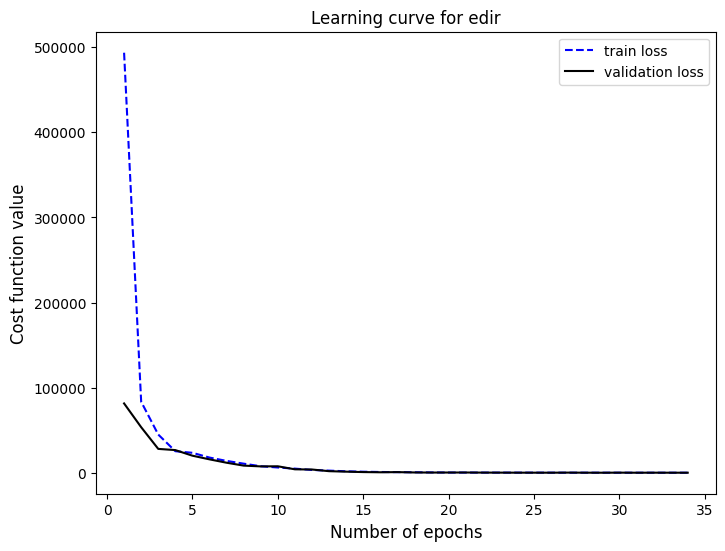

In [34]:
plot_learning_curve(loss_history)

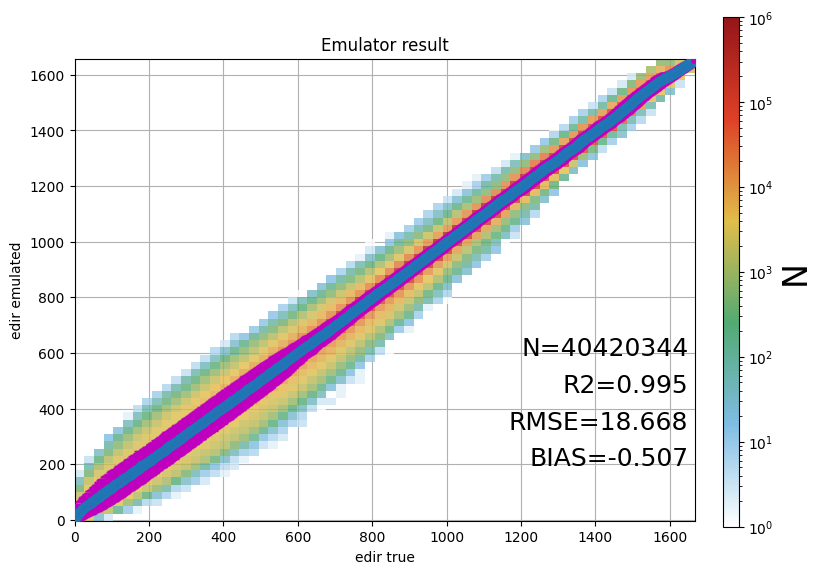

In [18]:
# Plot emulator results vs. true (libradtran RT model) values
plot_data(y_true=Y_val_edir,
          y_pred=edir_preds,
          title="Emulator result",
          x_label="edir true",
          y_label="edir emulated",
          error_bar_on=True,
          save_fig=False,
          fig_name=None)

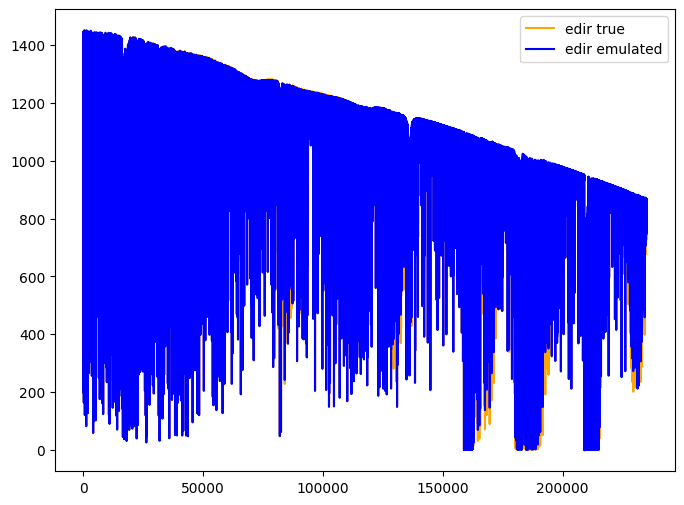

In [35]:
plot_random(edir_preds, scaled_X_val, Y_val_edir)

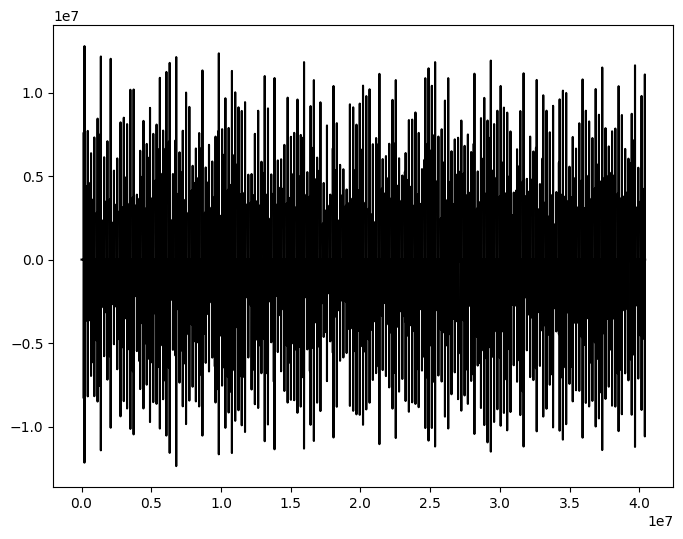

In [36]:
plot_relative_residuals(edir_preds, scaled_X_val, Y_val_edir)

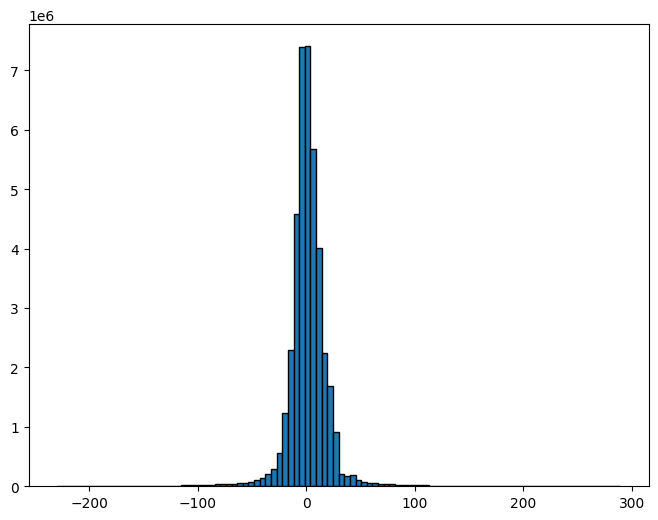

In [37]:
plot_residuals_hist(edir_preds, scaled_X_val, Y_val_edir)